In [1]:
import os
from torchvision.io import read_image
import numpy as np
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle as pkl
import itertools

class RoboticDataset(Dataset):
    def __init__(self, img_dir, val=False,train_size=0.8,load_y=True,transform=None,d_transform=None):
        self.img_idx_list = os.listdir(os.path.join(img_dir,'X'))
        if val:
            self.img_idx_list = self.img_idx_list[int(len(self.img_idx_list) * train_size):]
        else:
            self.img_idx_list = self.img_idx_list[:int(len(self.img_idx_list) * train_size)]
        self.img_dir = img_dir
        self.transform = transform
        self.d_transform = d_transform
        self.load_y = load_y

    def __len__(self):
        return len(self.img_idx_list)

    def __getitem__(self, idx):
        img_path = os.path.join(os.path.join(self.img_dir,'X'), self.img_idx_list[idx])
        if self.load_y:
            y_path = os.path.join(os.path.join(self.img_dir,'Y'), self.img_idx_list[idx] + ".npy")
            coordinates = torch.tensor(np.load(y_path))
        d_data = torch.tensor(np.load(os.path.join(img_path,"depth.npy")))
        rgbd_img = torch.empty(3,4,224,224)
        rgbd_img[:,3,:,:] = d_data
        for i in range(3):
            rgbd_img[i,:3,:,:] = read_image(os.path.join(os.path.join(img_path,'rgb'), "{}.png".format(i)))
        f = open(os.path.join(img_path,'field_id.pkl'),'rb')
        sample_id = pkl.load(f)
        f.close()
        if self.transform is not None:
            for i in range(3):
                rgbd_img[i,:3,:,:] = self.transform(rgbd_img[i,:3,:,:])
                rgbd_img[i,3,:,:] = self.d_transform(rgbd_img[i,3,:,:])
        if self.load_y:
            return rgbd_img, coordinates.float(), sample_id
        else:
            return rgbd_img.float(), sample_id

In [2]:
batch_size = 64

In [3]:
def find_mean_and_std():
    transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
    all_dataset = RoboticDataset("./lazydata/train",transform=transform,d_transform=transform,val=False,train_size=1)
    all_dataloader = torch.utils.data.DataLoader(all_dataset,batch_size=batch_size,num_workers=16)
    mean_,std_ = torch.zeros(4),torch.zeros(4)
    for batch_idx, (inputs, targets, sample_id) in enumerate(all_dataloader):
        inputs_rgb_imgs = inputs[:,:,:3,:,:].view(-1,3,224*224)
        inputs_d = inputs[:,:,3,:,:].view(-1,224*224)
        mean_[:3] += inputs_rgb_imgs.mean(axis=2).mean(axis=0)
        std_[:3] += inputs_rgb_imgs.std(axis=2).mean(axis=0)
        mean_[3] += inputs_d.mean(axis=1).mean(axis=0)
        std_[3] += inputs_d.std(axis=1).mean(axis=0)
    return mean_ / len(all_dataloader), std_ / len(all_dataloader)
find_mean_and_std()

(tensor([0.5570, 0.5416, 0.5187, 0.3739]),
 tensor([0.2366, 0.2176, 0.2187, 0.3120]))

In [3]:
DATA_MEAN = [0.5570, 0.5416, 0.5187, 0.3739]
DATA_STD = [0.2366, 0.2176, 0.2187, 0.3120]

normalize = transforms.Normalize(mean=DATA_MEAN[:3], std=DATA_STD[:3])
train_transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            normalize,
        ])
test_transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            normalize,
        ])
depth_transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=DATA_MEAN[3], std=DATA_STD[3]),
        ])

train_dataset = RoboticDataset("./lazydata/train",transform=train_transform,d_transform=depth_transform,val=False)
val_dataset = RoboticDataset("./lazydata/train",transform=test_transform,d_transform=depth_transform,val=True)
test_dataset = RoboticDataset("./lazydata/test",transform=test_transform,d_transform=depth_transform,load_y=False,val=False,train_size=1)

In [4]:
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=16)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=16)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=16)

In [20]:
import timm
net = timm.create_model("resnet50", pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 12)
net.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net = net.cuda()

In [21]:
n_epochs = 100
lr = 1e-3
optimizer = optim.Adam(net.parameters(), lr=lr)
# use cosine scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = nn.MSELoss()

In [22]:
##### Training
def train(epoch):
    net.train()
    train_loss = 0
    for batch_idx, (inputs, targets, sample_id) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        #inputs_rgb_imgs = inputs[:,:,:3,:,:].view(-1,3,224,224)
        #inputs_d = inputs[:,:,3,:,:].view(-1,1,224,224)
        #outputs = net(inputs_rgb_imgs)
        #outputs_d = net_d(inputs_d.expand(inputs_rgb_imgs.shape[0],3,224,224))
        #predy = ((outputs + outputs_d)/2).view(-1,3,12).mean(axis=1)
        predy = net(inputs.view(-1,4,224,224)).view(-1,3,12).mean(axis=1)
        loss = criterion(predy, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        if batch_idx % 50 == 0:
            print('[{}/{}]: Train Loss: {:.5f}\r'.format(batch_idx,len(trainloader),loss.item()))
    return train_loss/(batch_idx+1)

##### Validation
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets, sample_id) in enumerate(valloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            #inputs_rgb_imgs = inputs[:,:,:3,:,:].view(-1,3,224,224)
            #inputs_d = inputs[:,:,3,:,:].view(-1,1,224,224)
            #outputs = net(inputs_rgb_imgs)
            #outputs_d = net_d(inputs_d.expand(inputs_rgb_imgs.shape[0],3,224,224))
            #predy = ((outputs + outputs_d)/2).view(-1,3,12).mean(axis=1)
            predy = net(inputs.view(-1,4,224,224)).view(-1,3,12).mean(axis=1)
            loss = criterion(predy, targets)

            test_loss += loss.item()

            if batch_idx % 50 == 0:
                print('[{}/{}]: Val Loss: {:.5f}'.format(batch_idx,len(valloader),loss.item()))
    
    return test_loss

In [23]:
torch.cuda.empty_cache()

In [24]:
list_train_loss = []
list_val_loss = []
for epoch in range(n_epochs):
    #start = time.time()
    print("Epoch",epoch)
    train_loss = train(epoch)
    val_loss = test(epoch)
    
    scheduler.step(epoch-1) # step cosine scheduling
    
    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

Epoch 0
[0/43]: Train Loss: 0.05258
[0/11]: Val Loss: 0.00093
Epoch 1


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[0/43]: Train Loss: 0.00083
[0/11]: Val Loss: 0.00036
Epoch 2
[0/43]: Train Loss: 0.00026
[0/11]: Val Loss: 0.00061
Epoch 3
[0/43]: Train Loss: 0.00029
[0/11]: Val Loss: 0.00027
Epoch 4
[0/43]: Train Loss: 0.00024
[0/11]: Val Loss: 0.00110
Epoch 5
[0/43]: Train Loss: 0.00041
[0/11]: Val Loss: 0.00042
Epoch 6
[0/43]: Train Loss: 0.00017
[0/11]: Val Loss: 0.00025
Epoch 7
[0/43]: Train Loss: 0.00015
[0/11]: Val Loss: 0.00013
Epoch 8
[0/43]: Train Loss: 0.00018
[0/11]: Val Loss: 0.00030
Epoch 9
[0/43]: Train Loss: 0.00015
[0/11]: Val Loss: 0.00012
Epoch 10
[0/43]: Train Loss: 0.00012
[0/11]: Val Loss: 0.00015
Epoch 11
[0/43]: Train Loss: 0.00012
[0/11]: Val Loss: 0.00034
Epoch 12
[0/43]: Train Loss: 0.00021
[0/11]: Val Loss: 0.00025
Epoch 13
[0/43]: Train Loss: 0.00017
[0/11]: Val Loss: 0.00015
Epoch 14
[0/43]: Train Loss: 0.00012
[0/11]: Val Loss: 0.00013
Epoch 15
[0/43]: Train Loss: 0.00017
[0/11]: Val Loss: 0.00007
Epoch 16
[0/43]: Train Loss: 0.00007
[0/11]: Val Loss: 0.00014
Epoch 17


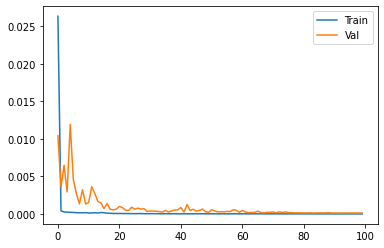

In [26]:
import matplotlib.pyplot as plt
plt.plot(np.arange(100),list_train_loss,label='Train')
plt.plot(np.arange(100),list_val_loss,label='Val')
plt.legend()

In [9]:
##### Training with all data
all_dataset = RoboticDataset("./lazydata/train",transform=train_transform,d_transform=depth_transform,val=False,train_size=1)
all_dataloader = torch.utils.data.DataLoader(all_dataset,batch_size=batch_size,num_workers=16)

net = timm.create_model("resnet50", pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 12)
net.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net = net.cuda()

n_epochs = 100
lr = 1e-3
optimizer = optim.Adam(net.parameters(), lr=lr)
# use cosine scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = nn.MSELoss()

def train(epoch):
    net.train()
    train_loss = 0
    for batch_idx, (inputs, targets, sample_id) in enumerate(all_dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        predy = net(inputs.view(-1,4,224,224)).view(-1,3,12).mean(axis=1)
        loss = criterion(predy, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        if batch_idx % 50 == 0:
            print('[{}/{}]: Train Loss: {:.5f}\r'.format(batch_idx,len(all_dataloader),loss.item()))
    return train_loss/(batch_idx+1)

for epoch in range(n_epochs):
    #start = time.time()
    print("Epoch",epoch)
    train_loss = train(epoch)

Epoch 0
[0/54]: Train Loss: 0.03218
[50/54]: Train Loss: 0.00068
Epoch 1
[0/54]: Train Loss: 0.00054
[50/54]: Train Loss: 0.00031
Epoch 2
[0/54]: Train Loss: 0.00046
[50/54]: Train Loss: 0.00026
Epoch 3
[0/54]: Train Loss: 0.00035
[50/54]: Train Loss: 0.00027
Epoch 4
[0/54]: Train Loss: 0.00039
[50/54]: Train Loss: 0.00022
Epoch 5
[0/54]: Train Loss: 0.00027
[50/54]: Train Loss: 0.00018
Epoch 6
[0/54]: Train Loss: 0.00034
[50/54]: Train Loss: 0.00015
Epoch 7
[0/54]: Train Loss: 0.00014
[50/54]: Train Loss: 0.00012
Epoch 8
[0/54]: Train Loss: 0.00013
[50/54]: Train Loss: 0.00011
Epoch 9
[0/54]: Train Loss: 0.00014
[50/54]: Train Loss: 0.00008
Epoch 10
[0/54]: Train Loss: 0.00024
[50/54]: Train Loss: 0.00008
Epoch 11
[0/54]: Train Loss: 0.00020
[50/54]: Train Loss: 0.00009
Epoch 12
[0/54]: Train Loss: 0.00015
[50/54]: Train Loss: 0.00009
Epoch 13
[0/54]: Train Loss: 0.00021
[50/54]: Train Loss: 0.00007
Epoch 14
[0/54]: Train Loss: 0.00016
[50/54]: Train Loss: 0.00005
Epoch 15
[0/54]: Tra

In [10]:
def get_test_output():
    id_list = []
    res_list = []
    with torch.no_grad():
        for batch_idx, (inputs, sample_id) in enumerate(testloader):
            inputs = inputs.cuda()
            res = net(inputs.view(-1,4,224,224)).view(-1,3,12).mean(axis=1)
            for i in range(len(sample_id)):
                id_list.append(sample_id[i])
                res_list.append(res[i].cpu().numpy())
    return id_list, res_list
id_list, res_list = get_test_output()

In [15]:
import pandas as pd
titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

res_df = pd.concat([pd.DataFrame(id_list),pd.DataFrame(res_list)],axis=1)
res_df.columns = titles

In [16]:
res_df.to_csv("submission.csv",index=None)

In [17]:
torch.save(net,"final.pt")